## Проект: вариант 1

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.

2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.

3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import scipy.stats as ss
from scipy.stats import chi2_contingency
import pingouin as pg
import requests 
from urllib.parse import urlencode 
from tqdm.auto import tqdm

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

### Задание 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [2]:
# Считываем данные
reg_data = pd.read_csv('~/shared/problem1-reg_data.csv', sep = ';')
auth_data = pd.read_csv('~/shared/problem1-auth_data.csv', sep = ';')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
reg_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [5]:
reg_data.isna().sum() # пропусков нет

reg_ts    0
uid       0
dtype: int64

In [6]:
reg_data.duplicated().sum() # дубликатов нет

0

In [7]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [8]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [9]:
auth_data.isna().sum() # пропусков нет

auth_ts    0
uid        0
dtype: int64

In [10]:
auth_data.duplicated().sum() # дубликатов нет

0

In [11]:
# Найдем число уникальных пользователей в обоих таблицах
print(f'Число уникальных пользователей при регистрации: {reg_data["uid"].nunique()}\n\
Число уникальных пользователей, заходивших в игру: {auth_data["uid"].nunique()}')

Число уникальных пользователей при регистрации: 1000000
Число уникальных пользователей, заходивших в игру: 1000000


Число уникальных значений совпадает, следовательно незарегистрированных пользователей в игре не было.

Так как даты в колонках reg_ts и auth_ts предствалены в формате unix time stamp, стоит преобразовать их в более читабельный формат.

In [12]:
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.date

In [13]:
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.date

In [14]:
reg_data.head()

,reg_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,2000-01-13,3
3,2000-05-28,4
4,2000-09-16,5


In [15]:
auth_data.head()

,auth_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,1999-07-25,2
3,1999-07-31,2
4,1999-08-05,2


In [16]:
# Минимальная дата регистрации
reg_data['reg_ts'].min()

datetime.date(1998, 11, 18)

In [17]:
# Максимальная дата авторизации
auth_data['auth_ts'].max()

datetime.date(2020, 9, 23)

In [78]:
def retention(reg_data, auth_data, start_date, end_date):
    
    # Приводим параметры start_date и end_date во временной формат
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Объединяем таблицы, с условием, что дата регистрации больше начальной даты и дата авторизации меньше конечной даты
    data = reg_data.merge(auth_data, on='uid').query('reg_ts >= @start_date and auth_ts <= @end_date')
    
    # Приводим колонки времени к формату даты
    data['reg_ts'] = pd.to_datetime(data['reg_ts']).dt.date
    data['auth_ts'] = pd.to_datetime(data['auth_ts']).dt.date
    
    # Считаем разницу между датой регистрации и датой авторизации в днях
    data['days_since_registration'] = (data['auth_ts'] - data['reg_ts']).dt.days
    
    # Формируем когорты по дате регистрации
    cohorts = data.groupby(['reg_ts', 'days_since_registration'], as_index=False)\
    .uid.nunique().rename(columns={'reg_ts': 'cohort'})
    
    # Переформатируем таблицу, оставив в индексах когорту, названия колонок заменим на количество дней с момента регистрации,
    # и заполним таблицу количеством уникальных пользователей
    retention_rate = cohorts.pivot(index='cohort', columns='days_since_registration', values='uid')
    
    # Считаем Retention Rate = доли возврата от первоначального размера когорты
    retention_rate = retention_rate.div(retention_rate.iloc[:,0], axis = 0)
    
    # Визуализируем данные о retention_rate
    ur_style = (retention_rate
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
    return ur_style
    

Тестируем функцию retention

In [79]:
retention(reg_data, auth_data, start_date = '2020-08-01', end_date = '2020-08-31')

days_since_registration,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
cohort,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-08-01,100.00%,1.92%,4.45%,4.31%,5.57%,5.91%,7.63%,6.37%,4.51%,6.37%,4.78%,5.11%,5.91%,4.71%,4.51%,4.91%,3.65%,4.45%,3.78%,4.11%,4.64%,3.38%,4.05%,3.78%,4.18%,4.11%,2.52%,3.12%,3.19%,3.05%,2.72%
2020-08-02,100.00%,2.58%,4.04%,4.37%,5.17%,6.49%,6.63%,6.03%,4.51%,5.30%,5.50%,5.17%,4.57%,5.50%,4.64%,4.24%,4.97%,5.57%,4.51%,3.78%,3.91%,4.57%,3.84%,3.91%,3.98%,3.25%,3.38%,2.98%,3.38%,3.31%,
2020-08-03,100.00%,1.72%,4.30%,4.03%,5.56%,6.15%,7.54%,5.29%,4.96%,4.89%,5.36%,5.09%,5.62%,5.62%,4.23%,3.84%,3.90%,4.96%,5.62%,3.84%,3.84%,4.10%,4.37%,2.98%,3.90%,3.17%,4.37%,3.37%,3.24%,,
2020-08-04,100.00%,2.05%,3.57%,4.69%,5.22%,5.28%,6.47%,5.15%,4.43%,4.69%,5.28%,5.61%,4.03%,4.95%,3.57%,4.76%,5.09%,4.56%,4.36%,3.50%,4.10%,3.96%,3.04%,4.43%,2.91%,3.17%,2.97%,3.17%,,,
2020-08-05,100.00%,2.57%,3.49%,4.02%,5.74%,5.08%,7.78%,6.13%,4.22%,4.75%,4.75%,5.67%,5.21%,4.81%,3.69%,3.76%,3.56%,4.61%,4.22%,3.69%,4.15%,3.36%,3.30%,3.30%,3.76%,2.97%,3.56%,,,,
2020-08-06,100.00%,1.71%,5.07%,5.73%,5.60%,5.73%,7.50%,6.06%,5.00%,5.79%,5.13%,5.20%,4.87%,4.54%,4.74%,5.53%,4.21%,4.67%,4.21%,4.08%,4.15%,3.82%,3.88%,3.36%,3.82%,3.09%,,,,,
2020-08-07,100.00%,2.17%,3.09%,5.26%,5.32%,5.98%,7.16%,6.18%,5.12%,4.99%,4.93%,5.72%,5.19%,4.66%,5.12%,4.14%,4.60%,4.53%,5.12%,4.14%,3.48%,4.73%,3.09%,3.81%,3.88%,,,,,,
2020-08-08,100.00%,2.43%,4.79%,4.20%,5.45%,5.45%,7.22%,6.30%,3.94%,4.79%,5.25%,5.12%,4.00%,5.58%,4.86%,4.27%,4.27%,4.53%,3.41%,4.27%,4.33%,3.54%,4.33%,3.35%,,,,,,,
2020-08-09,100.00%,2.10%,3.93%,4.65%,5.37%,7.07%,6.29%,6.61%,4.45%,4.91%,4.45%,6.22%,5.37%,5.63%,3.99%,4.65%,4.32%,5.30%,4.52%,4.58%,4.65%,3.93%,4.13%,,,,,,,,


### Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [20]:
# Считываем данные, используя API
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'  

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

df = pd.read_csv(download_url, sep=';')

In [21]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [23]:
df.isna().sum() # пропусков нет

user_id      0
revenue      0
testgroup    0
dtype: int64

In [24]:
df.duplicated().sum() # дубликатов нет

0

In [25]:
# Количество уникальных пользователей
df.user_id.nunique()

404770

In [26]:
df.groupby('testgroup').user_id.nunique()

testgroup
a    202103
b    202667
Name: user_id, dtype: int64

In [27]:
paying_uers_control = df.query("revenue>0 and testgroup =='a'").revenue.count()
print('Платящих пользователей в контрольной группе', paying_uers_control)
paying_uers_test = df.query("revenue>0 and testgroup =='b'").revenue.count()
print('Платящих пользователей в тестовой группе', paying_uers_test)

Платящих пользователей в контрольной группе 1928
Платящих пользователей в тестовой группе 1805


Исходя из условий задания определем группу $a$ как контрольную (всего 202103 юзеров, 1928 платящих), группу $b$ как тестовую (всего 202667 юзеров, 1805 платящих)

In [28]:
df_control = df.query("testgroup=='a'")
df_test = df.query("testgroup=='b'")

Посмотрим на метрики в группах

In [29]:
# ARPU в контрольной группе
arpu_control = round(df_control.revenue.sum()/df_control.user_id.count(), 2)
arpu_control

25.41

In [30]:
# ARPU в тестовой группе
arpu_test = round(df_test.revenue.sum()/df_test.user_id.count(), 2)
arpu_test

26.75

In [31]:
# Конверсия в покупку в контрольной группе
cr_control = df_control.query("revenue>0").user_id.count()/df_control.user_id.count()
cr_control

0.009539690157988749

In [32]:
# Конверсия в покупку в тестовой группе
cr_test = df_test.query("revenue>0").user_id.count()/df_test.user_id.count()
cr_test

0.008906235351586593

In [33]:
# ARPPU в контрольной группе
arppu_control = round(arpu_control/cr_control, 2)
arppu_control

2663.61

In [34]:
# ARPPU в тестовой группе
arppu_test = round(arpu_test/cr_test, 2)
arppu_test

3003.51

In [35]:
# Доход в контрольной группе
revenue_control = df_control.revenue.sum()
revenue_control

5136189

In [36]:
# Доход в тестовой группе
revenue_test = df_test.revenue.sum()
revenue_test

5421603

Соберем все полученные значения в одну таблицу

In [37]:
metrics = df.groupby('testgroup').agg({'user_id': 'count'}).rename(columns={'user_id': 'users'})
metrics

,users
testgroup,
a,202103
b,202667


In [38]:
data_groups = pd.DataFrame({'testgroup': ['a', 'b'], 'paying_users': [paying_uers_control, paying_uers_test],
            'cr':[round(cr_control*100, 2), round(cr_test*100, 2)], 'ARPU':[arpu_control, arpu_test], 
            'ARPPU':[arppu_control, arppu_test], 
            'revenue_sum':[revenue_control, revenue_test]}).set_index('testgroup')


In [39]:
metrics=metrics.join(data_groups)

In [40]:
metrics

,users,paying_users,cr,ARPU,ARPPU,revenue_sum
testgroup,,,,,,
a,202103,1928,0.95,25.41,2663.61,5136189
b,202667,1805,0.89,26.75,3003.51,5421603


In [41]:
# ARPU в тестовой группе больше на 5.27 %, чем в контрольной
(metrics.loc['b'].ARPU-metrics.loc['a'].ARPU)/metrics.loc['a'].ARPU*100

5.273514364423455

In [42]:
# ARPPU в тестовой группе больше на 12.76 %, чем в контрольной
(metrics.loc['b'].ARPPU-metrics.loc['a'].ARPPU)/metrics.loc['a'].ARPPU*100

12.760877155439426

In [43]:
# Конверсия в покупку в контрольной группе больше на 6.7%, чем в тестовой
(metrics.loc['a'].cr-metrics.loc['b'].cr)/metrics.loc['b'].cr*100

6.741573033707858

Необходимо статистически сравнить различия по трем метрикам: ARPU, ARPPU, CR в двух группах.

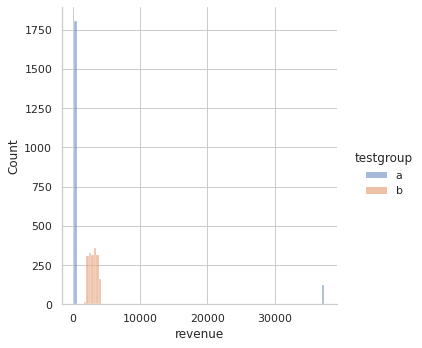

In [44]:
# Посмотрим на распределение revenue для разных групп
sns.displot(data=df.query("revenue > 0"), x='revenue', hue='testgroup', kde=False)

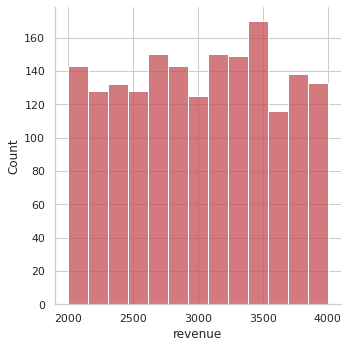

In [45]:
# Распределение revenue в тестовой группе
sns.displot(data=df.query("testgroup == 'b' and revenue > 0"), x='revenue', kde=False, color='r')

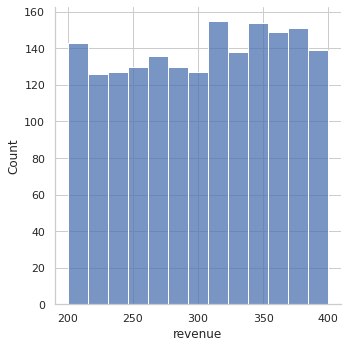

In [46]:
# Распределение revenue в контрольной группе без экстремально высоких чеков
sns.displot(data=df.query("testgroup == 'a' and revenue > 0 and revenue<10000"), x='revenue', kde=False, color='b')

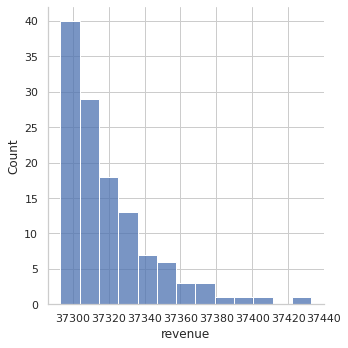

In [47]:
# Распределение revenue экстремально высоких чеков в контрольной группе 
sns.displot(data=df.query("testgroup == 'a' and revenue > 30000"), x='revenue', kde=False, color='b')

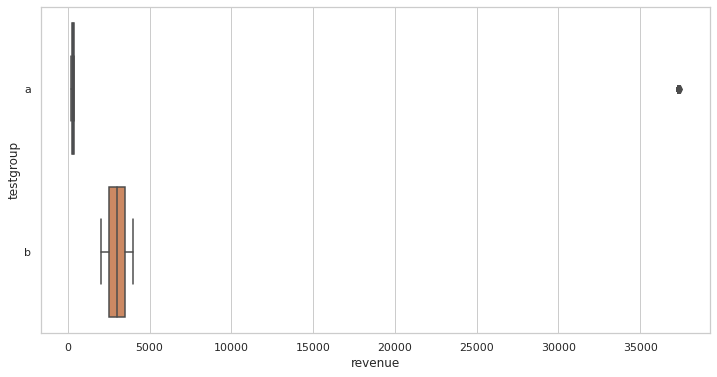

In [48]:
# Боксплот
sns.boxplot(data = df.query("revenue > 0"), x='revenue', y='testgroup')

Визуально распределения не выглядят нормальными. Также есть выброс в контрольной группе.

In [49]:
# Проверим нормальность распределения revenue платящих пользователей в группах
pg.normality(df.query("revenue > 0"), "revenue", "testgroup", "normaltest")

,W,pval,normal
a,1394.945784,1.234161e-303,False
b,1068.860008,7.943249e-233,False


In [50]:
df_control.query("revenue>0").describe()

,user_id,revenue
count,1928.000000,1928.000000
mean,200152.677905,2663.998444
std,116596.504905,9049.039763
min,73.000000,200.000000
25%,99323.000000,257.000000
50%,199854.500000,311.000000
75%,299664.250000,361.000000
max,404768.000000,37433.000000


In [51]:
df_test.query("revenue>0").describe()

,user_id,revenue
count,1805.000000,1805.000000
mean,205834.548476,3003.658172
std,116400.045485,572.619709
min,161.000000,2000.000000
25%,106815.000000,2513.000000
50%,206651.000000,3022.000000
75%,304907.000000,3478.000000
max,404526.000000,4000.000000


Медианное значение revenue контрольной группы (3022) в 10 раз больше медианы тестовой группы (311).

Изучим подробнее выброс в контрольной группе

In [52]:
# Количество клиентов с экстремально высоким чеком
df_control.query("revenue>35000").user_id.count()

123

In [53]:
# Сумма покупок клиентов с экстремально высоким чеком
df_control.query("revenue>35000").revenue.sum()

4590252

In [54]:
# Доля клиентов с экстремально высоким чеком от всех платщих пользователей в %
df_control.query("revenue>35000").user_id.count()/df_control.query("revenue>0").user_id.count()*100

6.379668049792531

In [55]:
# Доля выручки клиентов с экстремально высоким чеком от общей суммы выручки контрольной группы
4590252/df_control.revenue.sum()*100

89.37077665950378

В контрольной группе 89% выручки от всех платящих пользователей делают 123 клиента, т.е. 6.38 %. Предположим, что настолько большие чеки не баг, а действительно крупные покупки по акционным предложениям. Распределение в тестовой группе также не яляется нормальным, хоть и выглядит более равномерным.

#### Метрика Конверсия (conversion rate, CR) — отношение числа пользователей, которые выполнили какое-либо целевое действие к общему числу пользователей.

Так как это категориальная метрика (сконвертировался в покупку или нет), будем использовать метод хи-квадрат. 

- $H_0$: нет взаимосвязи между конверсией в покупку и набором акционных предложений, статистически значимых различий между конверсиями двух групп нет 
- $H_1$: есть взаимосвязь между конверсией в покупку и набором акционных предложений, статистически значимые различия между конверсиями двух групп есть


In [56]:
# Создаем новую колонку в df о факте конверсии 0 -нет, 1 -да
df['conversion'] = (df['revenue'] != 0).astype(int)
df.tail()

,user_id,revenue,testgroup,conversion
404765,404766,0,a,0
404766,404767,0,b,0
404767,404768,231,a,1
404768,404769,0,a,0
404769,404770,0,b,0


In [57]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.conversion, df.testgroup))

In [58]:
stat, p

(4.374729521260405, 0.03647561892312613)

In [59]:
# По значению p-value
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


Отклоняем нулевую гипотезу, так как p-value = 0.036, что меньше 0.05. Статистически значимые различия между конверсиями групп $a$ и $b$ есть, конверсия в контрольной группе выше.

#### Метрика ARPU  – средний доход с привлеченного пользователя. 

- $H_0$: - среднее значение выручки пользователя тестовой группы не отличается от среднего значения выручки пользователя контрольной группы

- $H_1$: - среднее значение выручки пользователя тестовой группы отличается от среднего значения выручки пользователя контрольной группы

Наблюдения в обеих группах распределены не нормально, также имеются большие выбросы, поэтому для проверки стат значимости различий будем использовать метод bootstrap.

In [60]:
df_a = df.query("testgroup=='a'")
df_b = df.query("testgroup=='b'")

In [61]:
df_a_1 = df.query("testgroup=='a' and revenue>0")
df_b_1 = df.query("testgroup=='b' and revenue>0")

In [62]:
# Данные для двух выборок
data_a = df_a.revenue
data_b = df_b.revenue

# Количество бутстреп-выборок
num_samples = 1000

# Массив для хранения разниц средних значений бутстреп-выборок
bootstrap_diff_means = np.zeros(num_samples)

# Генерация бутстреп-выборок и вычисление разниц средних
for i in range(num_samples):
    # Генерация бутстреп-выборок с заменой
    bootstrap_sample_a = np.random.choice(data_a, size=len(data_a), replace=True)
    bootstrap_sample_b = np.random.choice(data_b, size=len(data_b), replace=True)
    
    # Средние значения для бутстреп-выборок
    bootstrap_mean_a = np.mean(bootstrap_sample_a)
    bootstrap_mean_b = np.mean(bootstrap_sample_b)
    
    # Разница средних значений
    bootstrap_diff_means[i] = bootstrap_mean_a - bootstrap_mean_b

# Вычисление 95%-го доверительного интервала для разницы средних
confidence_interval = np.percentile(bootstrap_diff_means, [2.5, 97.5])

print("95% Confidence interval for the difference of means:", confidence_interval)


95% Confidence interval for the difference of means: [-5.42584692  2.94016661]


In [63]:
group_a = df_a.revenue
group_b = df_b.revenue

num_samples = 1000
bootstrap_diffs = np.zeros(num_samples)

# Бутстреп-выборки
for i in range(num_samples):
    bootstrap_group_a = np.random.choice(group_a, size=len(group_a), replace=True)
    bootstrap_group_b = np.random.choice(group_b, size=len(group_b), replace=True)
     
    bootstrap_diff = np.mean(bootstrap_group_a) - np.mean(bootstrap_group_b)
    bootstrap_diffs[i] = bootstrap_diff

# Вычисляем p-значение
observed_diff = np.mean(group_a) - np.mean(group_b)
p_value = np.mean(bootstrap_diffs >= observed_diff)
 
print("Bootstrap p-value:", p_value)


Bootstrap p-value: 0.487


Доверительный интервал проходит через 0, p-value = 0.487, что больше 0.05, нет оснований отклонять нулевую гипотезу для метрики ARPU. Среднее значение выручки пользователя тестовой группы не отличается от среднего значения выручки пользователя контрольной группы.

#### Метрика ARPPU  – средний доход на платящего пользователя (клиента). 

- $H_0$: - среднее значение выручки платящего пользователя тестовой группы не отличается от среднего значения выручки платящего пользователя контрольной группы

- $H_1$: - среднее значение выручки платящего пользователя тестовой группы отличается от среднего значения выручки платящего пользователя контрольной группы

In [64]:
# Данные для двух выборок
data_a_1 = df_a_1.revenue
data_b_1 = df_b_1.revenue

# Количество бутстреп-выборок
num_samples = 1000

# Массив для хранения разниц средних значений бутстреп-выборок
bootstrap_diff_means = np.zeros(num_samples)

# Генерация бутстреп-выборок и вычисление разниц средних
for i in range(num_samples):
    # Генерация бутстреп-выборок с заменой
    bootstrap_sample_a = np.random.choice(data_a_1, size=len(data_a_1), replace=True)
    bootstrap_sample_b = np.random.choice(data_b_1, size=len(data_b_1), replace=True)
    
    # Средние значения для бутстреп-выборок
    bootstrap_mean_a = np.mean(bootstrap_sample_a)
    bootstrap_mean_b = np.mean(bootstrap_sample_b)
    
    # Разница средних значений
    bootstrap_diff_means[i] = bootstrap_mean_a - bootstrap_mean_b

# Вычисление 95%-го доверительного интервала для разницы средних
confidence_interval = np.percentile(bootstrap_diff_means, [2.5, 97.5])

print("95% Confidence interval for the difference of means:", confidence_interval)


95% Confidence interval for the difference of means: [-730.052782     61.69937661]


In [65]:
group_a_1 = df_a_1.revenue
group_b_2 = df_b_1.revenue

num_samples = 1000
bootstrap_diffs = np.zeros(num_samples)

# Бутстреп-выборки
for i in range(num_samples):
    bootstrap_group1 = np.random.choice(group_a_1, size=len(group_a_1), replace=True)
    bootstrap_group2 = np.random.choice(group_b_2, size=len(group_b_2), replace=True)
     
    bootstrap_diff = np.mean(bootstrap_group1) - np.mean(bootstrap_group2)
    bootstrap_diffs[i] = bootstrap_diff

# Вычисляем p-значение
observed_diff = np.mean(group_a_1) - np.mean(group_b_2)
p_value = np.mean(bootstrap_diffs >= observed_diff)
 
print("Bootstrap p-value:", p_value)


Bootstrap p-value: 0.488


Доверительный интервал проходит через 0, p-value = 0.488, что больше 0.05, нет оснований отклонять нулевую гипотезу для метрики ARPPU. Среднее значение выручки платящего пользователя тестовой группы не отличается от среднего значения выручки платящего пользователя контрольной группы.

### Выводы
Исходя из полученных результатов статистических тестов можно сделать следующие выводы:
- набор акционных предложений никак не повлиял на среднюю выручку с пользователя;
- конверсия в покупку в контрольной группе выше чем в тестовой, различия статистически значимы

В контрольной группе имеются выбросы, которые существенно влияют на оценку среднего значения revenue, поэтому нельзя однозначно утверждать, какой набор акционных предложений лучше. Следует дополнительно проанализировать выбросы, причины их возникновения в контрольной группе и отсутствия в тестовой.

На данном этапе не рекоммендуется включать нововведения на всех пользователей.

## Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

В первом случае я бы предложила следующие метрики для оценки результатов прошедшего события:
 - Дневная аудитория (DAU) — количество уникальных пользователей, которые зашли в игру в течение суток.
 - Месячная аудитория (MAU) — количество уникальных пользователей, которые зашли в игру в течение месяца. По отношению средней дневной аудитории к месячной можно понимать частоту использования игры во время события.
 - Конверсия в событие (conversion rate, CR) — отношение числа пользователей, которые приняли участие в событии к общему числу пользователей.
 - Конверсия в завершение события — отношение числа пользователей, которые участвовали в событии до последнего дня к общему числу пользователей, которые приняли участие в событии.
 - Retention n-го дня — сколько игроков, пришедших в определенный день тематического события вернулось в продукт на n-ый день с момента своего прихода.
 - Коэффициента оттока (churn rate) — количество игроков, которые ушли из игры после прошедего события.
 - ARPU  - средний доход с привлечённого пользователя.
 - ARPPU - средний доход на платящего пользователя.
 - Доход, полученный с пользователей во время прохождения тематического события.
 - Средняя продолжительность сессии.
 - Количество сессий всего.
 
Во втором случае я бы оставила все предыдущие метрики и добавила:
 - Процент откатившихся игроков от числа всех участников события.
 - Конверсия возвращение в событие после отката - отношение числа пользователей, продолживших событие после отката к общему числу откатившихся пользователей.
 - Конверсия в завершение события откатившихся хотя бы раз игроков - отношение числа пользователей, завершивших событие, у которых был откат к общему числу откатившихся пользователей.